In [1]:
using TimeSeries
using DataTables
using CSV
using Proj4
using DataFrames: head
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
include("src/preprocessing.jl")
include("src/utils.jl")
;

  likely near In[1]:3
  likely near In[1]:3


In [2]:
isdList=read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
hourly_cat=read_Stations(isdSubset)
TnTx_dict = Dict{Int, Dict{Hour,DataTable}}()
for istation in 1:4
    TnTx_dict[istation] = Dict{Hour,DataTable}()
    for hr in Hour(0):Hour(1):Hour(24)
        TnTx = test_data(hourly_cat, istation, hr)
        TnTx_dict[istation][hr] = TnTx
    end
end
        
waterloo = hourly_cat[hourly_cat[:station].values.==3,:]
waterloo_TnTx_dict = TnTx_dict[3]
;

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] anynull(::NullableArrays.NullableArray{Float64,1}) at ./deprecated.jl:57
 [3] convert(::Type{Array{Float64,2}}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:545
 [4] convert(::Type{Array{T,2} where T}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:535
 [5] #read_isdList#4(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:31
 [6] read_isdList() at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:26
 [7] include_string(::String, ::String) at ./loading.jl:515
 [8] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages/v0.6/Compat/src/Compat.jl:407
 [9] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages/v0.6/IJulia/src/execute_req

In [3]:
begin
    hr = Hour(23)
    low = Hour(8)
    peak = Hour(20)
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    apr3_low = TnTx_low[TnTx_low[:ts_day].values.==DateTime(2015,4,4),:]
    apr3_peak = TnTx_peak[TnTx_peak[:ts_day].values.==DateTime(2015,4,4),:]
    
    global apr3_realmax = get(apr3_low[1,:Tx])
    global apr3_measured = get(apr3_peak[1,:Tx])
    println(apr3_realmax)
    println(apr3_measured)
end

7.2
16.1


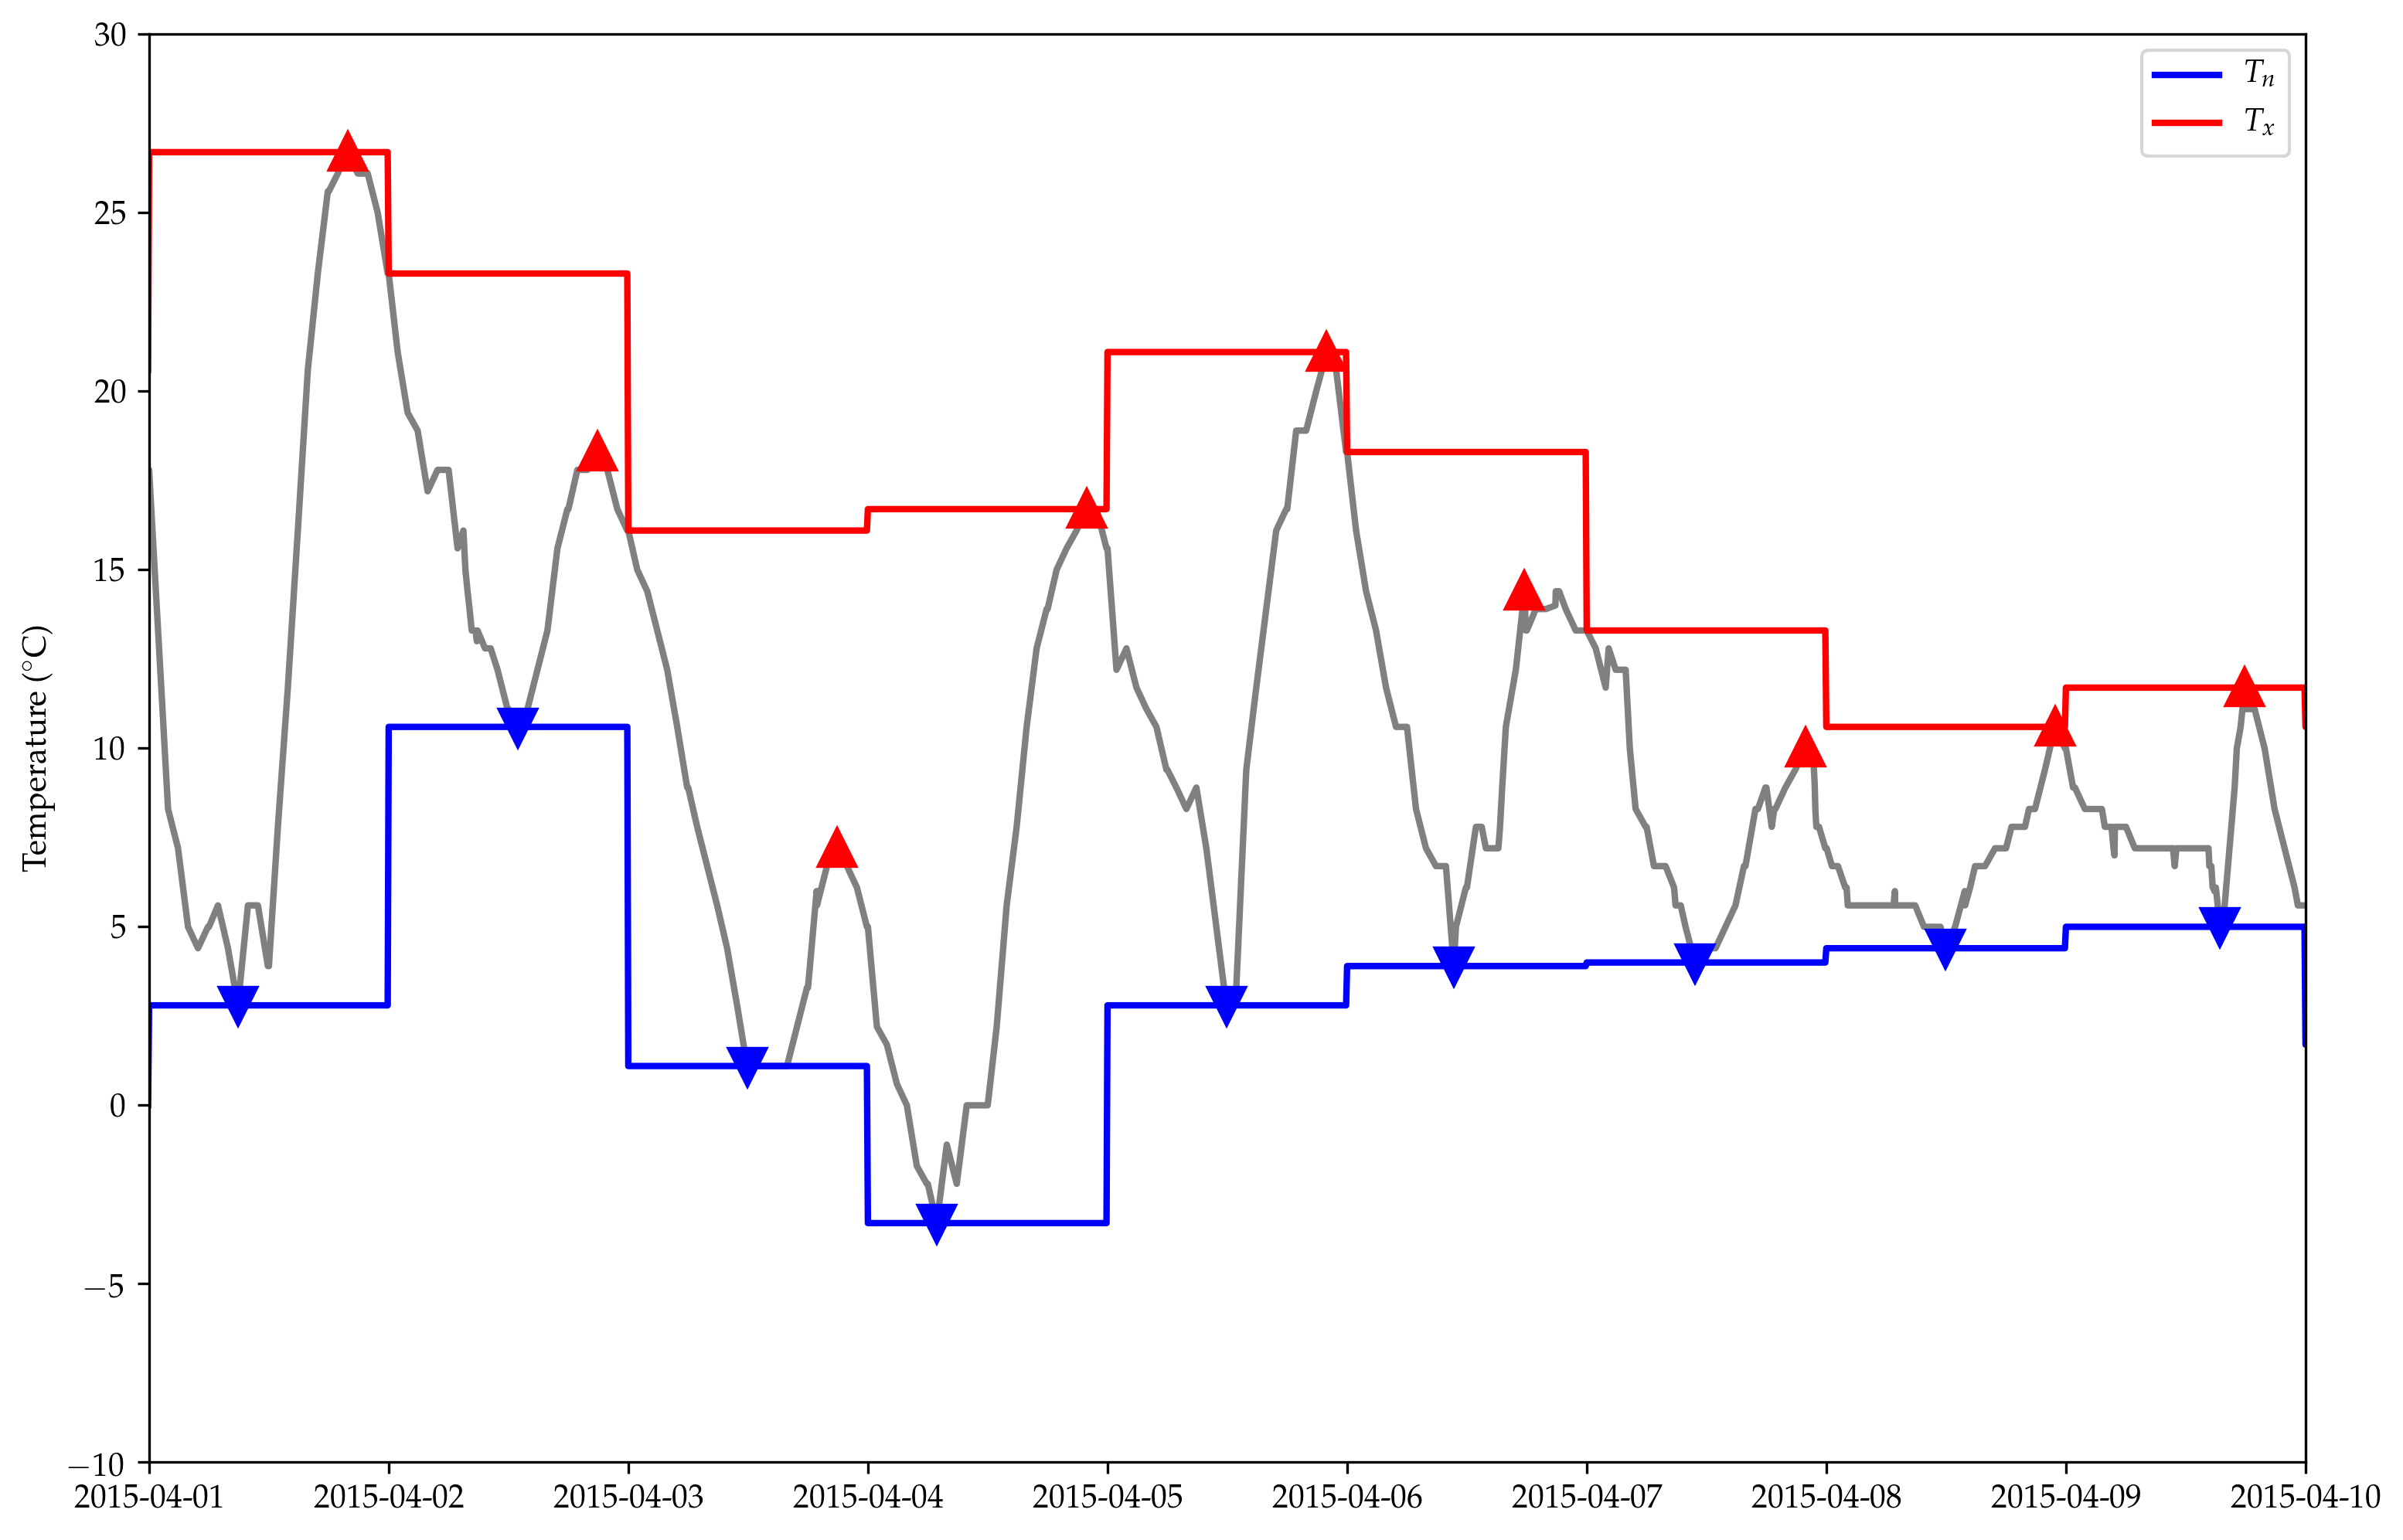

In [4]:
begin
    hr = Hour(23)
    peak = Hour(20)
    low = Hour(8)
    waterloo[:ts_day] = [measurement_date(t,hr) for t in waterloo[:ts].values]
    test_trimmed = join(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey", linewidth=2)
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    plt.plot(TnTx_low[:Tx_time].values, TnTx_low[:Tx].values, 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.plot(TnTx_peak[:Tn_time].values, TnTx_peak[:Tn].values, 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=10,
        )
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,10)) # random interval
    plt.ylim(-10,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    plt.legend()
    plt.savefig("figures/waterloo_triangles.png", bbox_inches="tight")
    plt.savefig("figures/waterloo_triangles.pdf", bbox_inches="tight")
end;

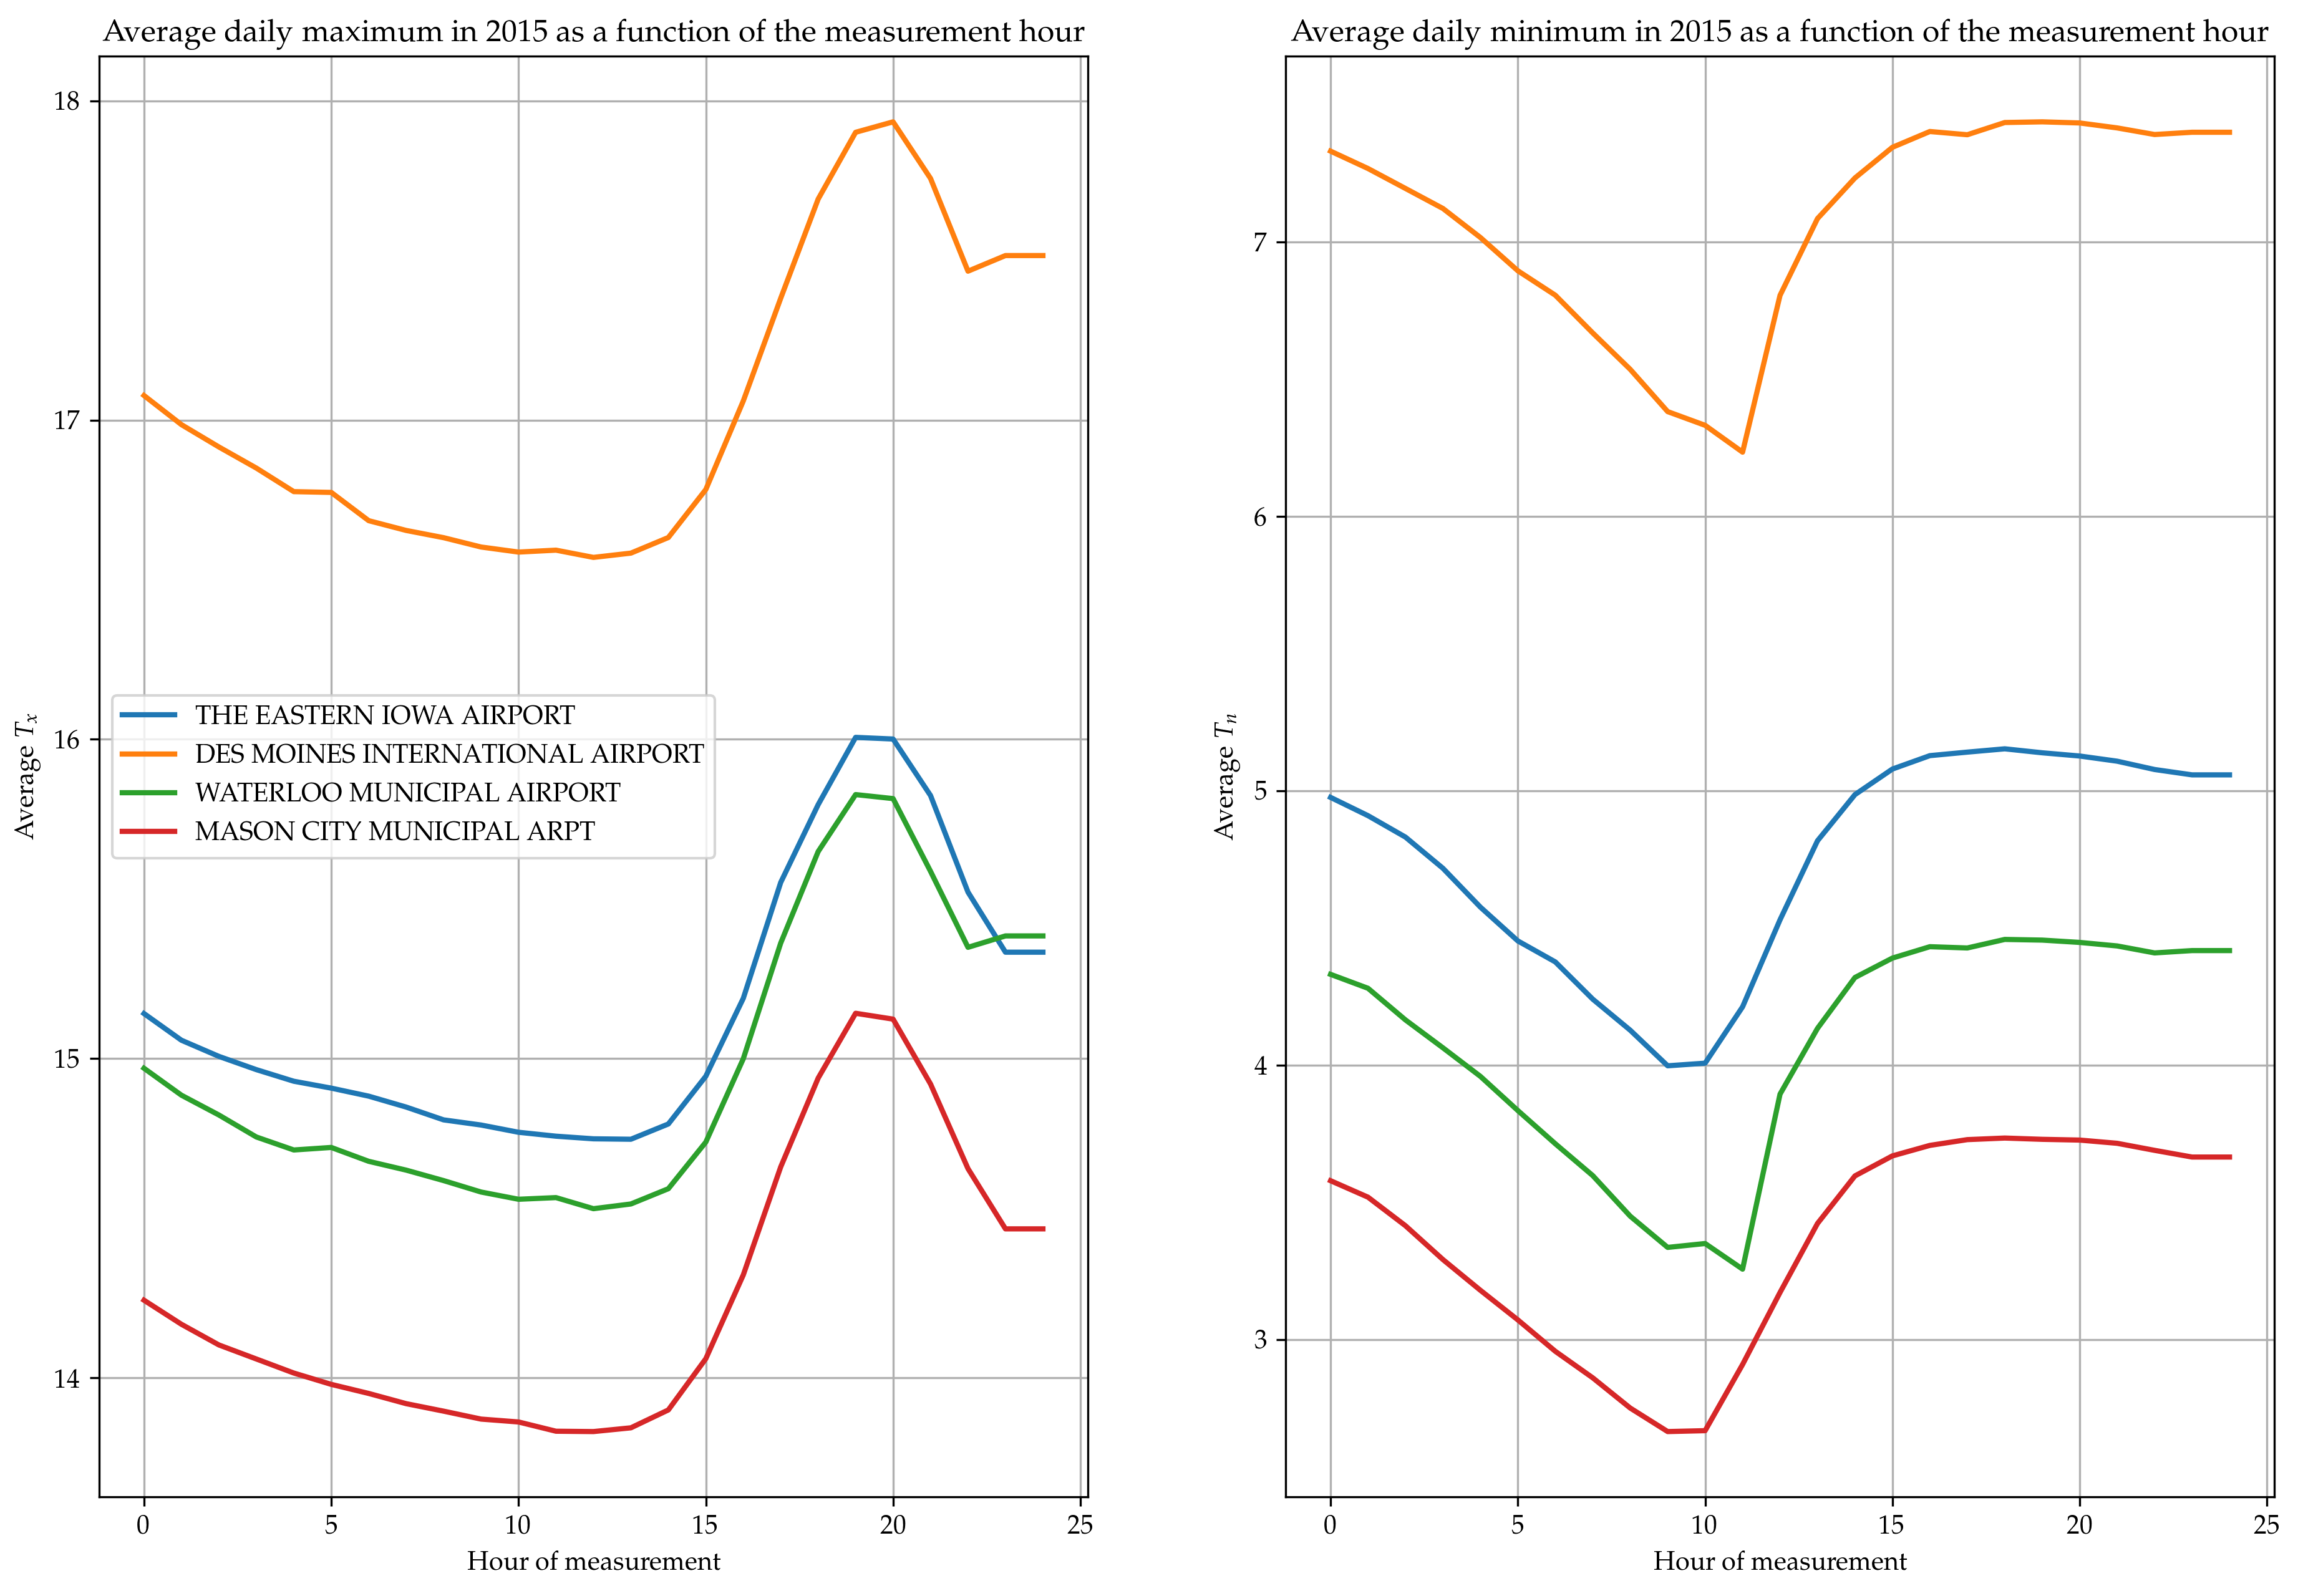

In [9]:
begin
plt.subplot(1,2,1)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[:Tx].values))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_x$")
    plt.xlabel("Hour of measurement")
    plt.title("Average daily maximum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.legend(loc="center left")
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[:Tn].values))
        end
    end

    for station in 1:4
        plt.plot(0:24, statdict[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"Average $T_n$")
    plt.xlabel("Hour of measurement")
    plt.title("Average daily minimum in 2015 as a function of the measurement hour")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("figures/waterloo_avgTnTx.png", bbox_inches="tight")
plt.savefig("figures/waterloo_avgTnTx.pdf", bbox_inches="tight")
end;

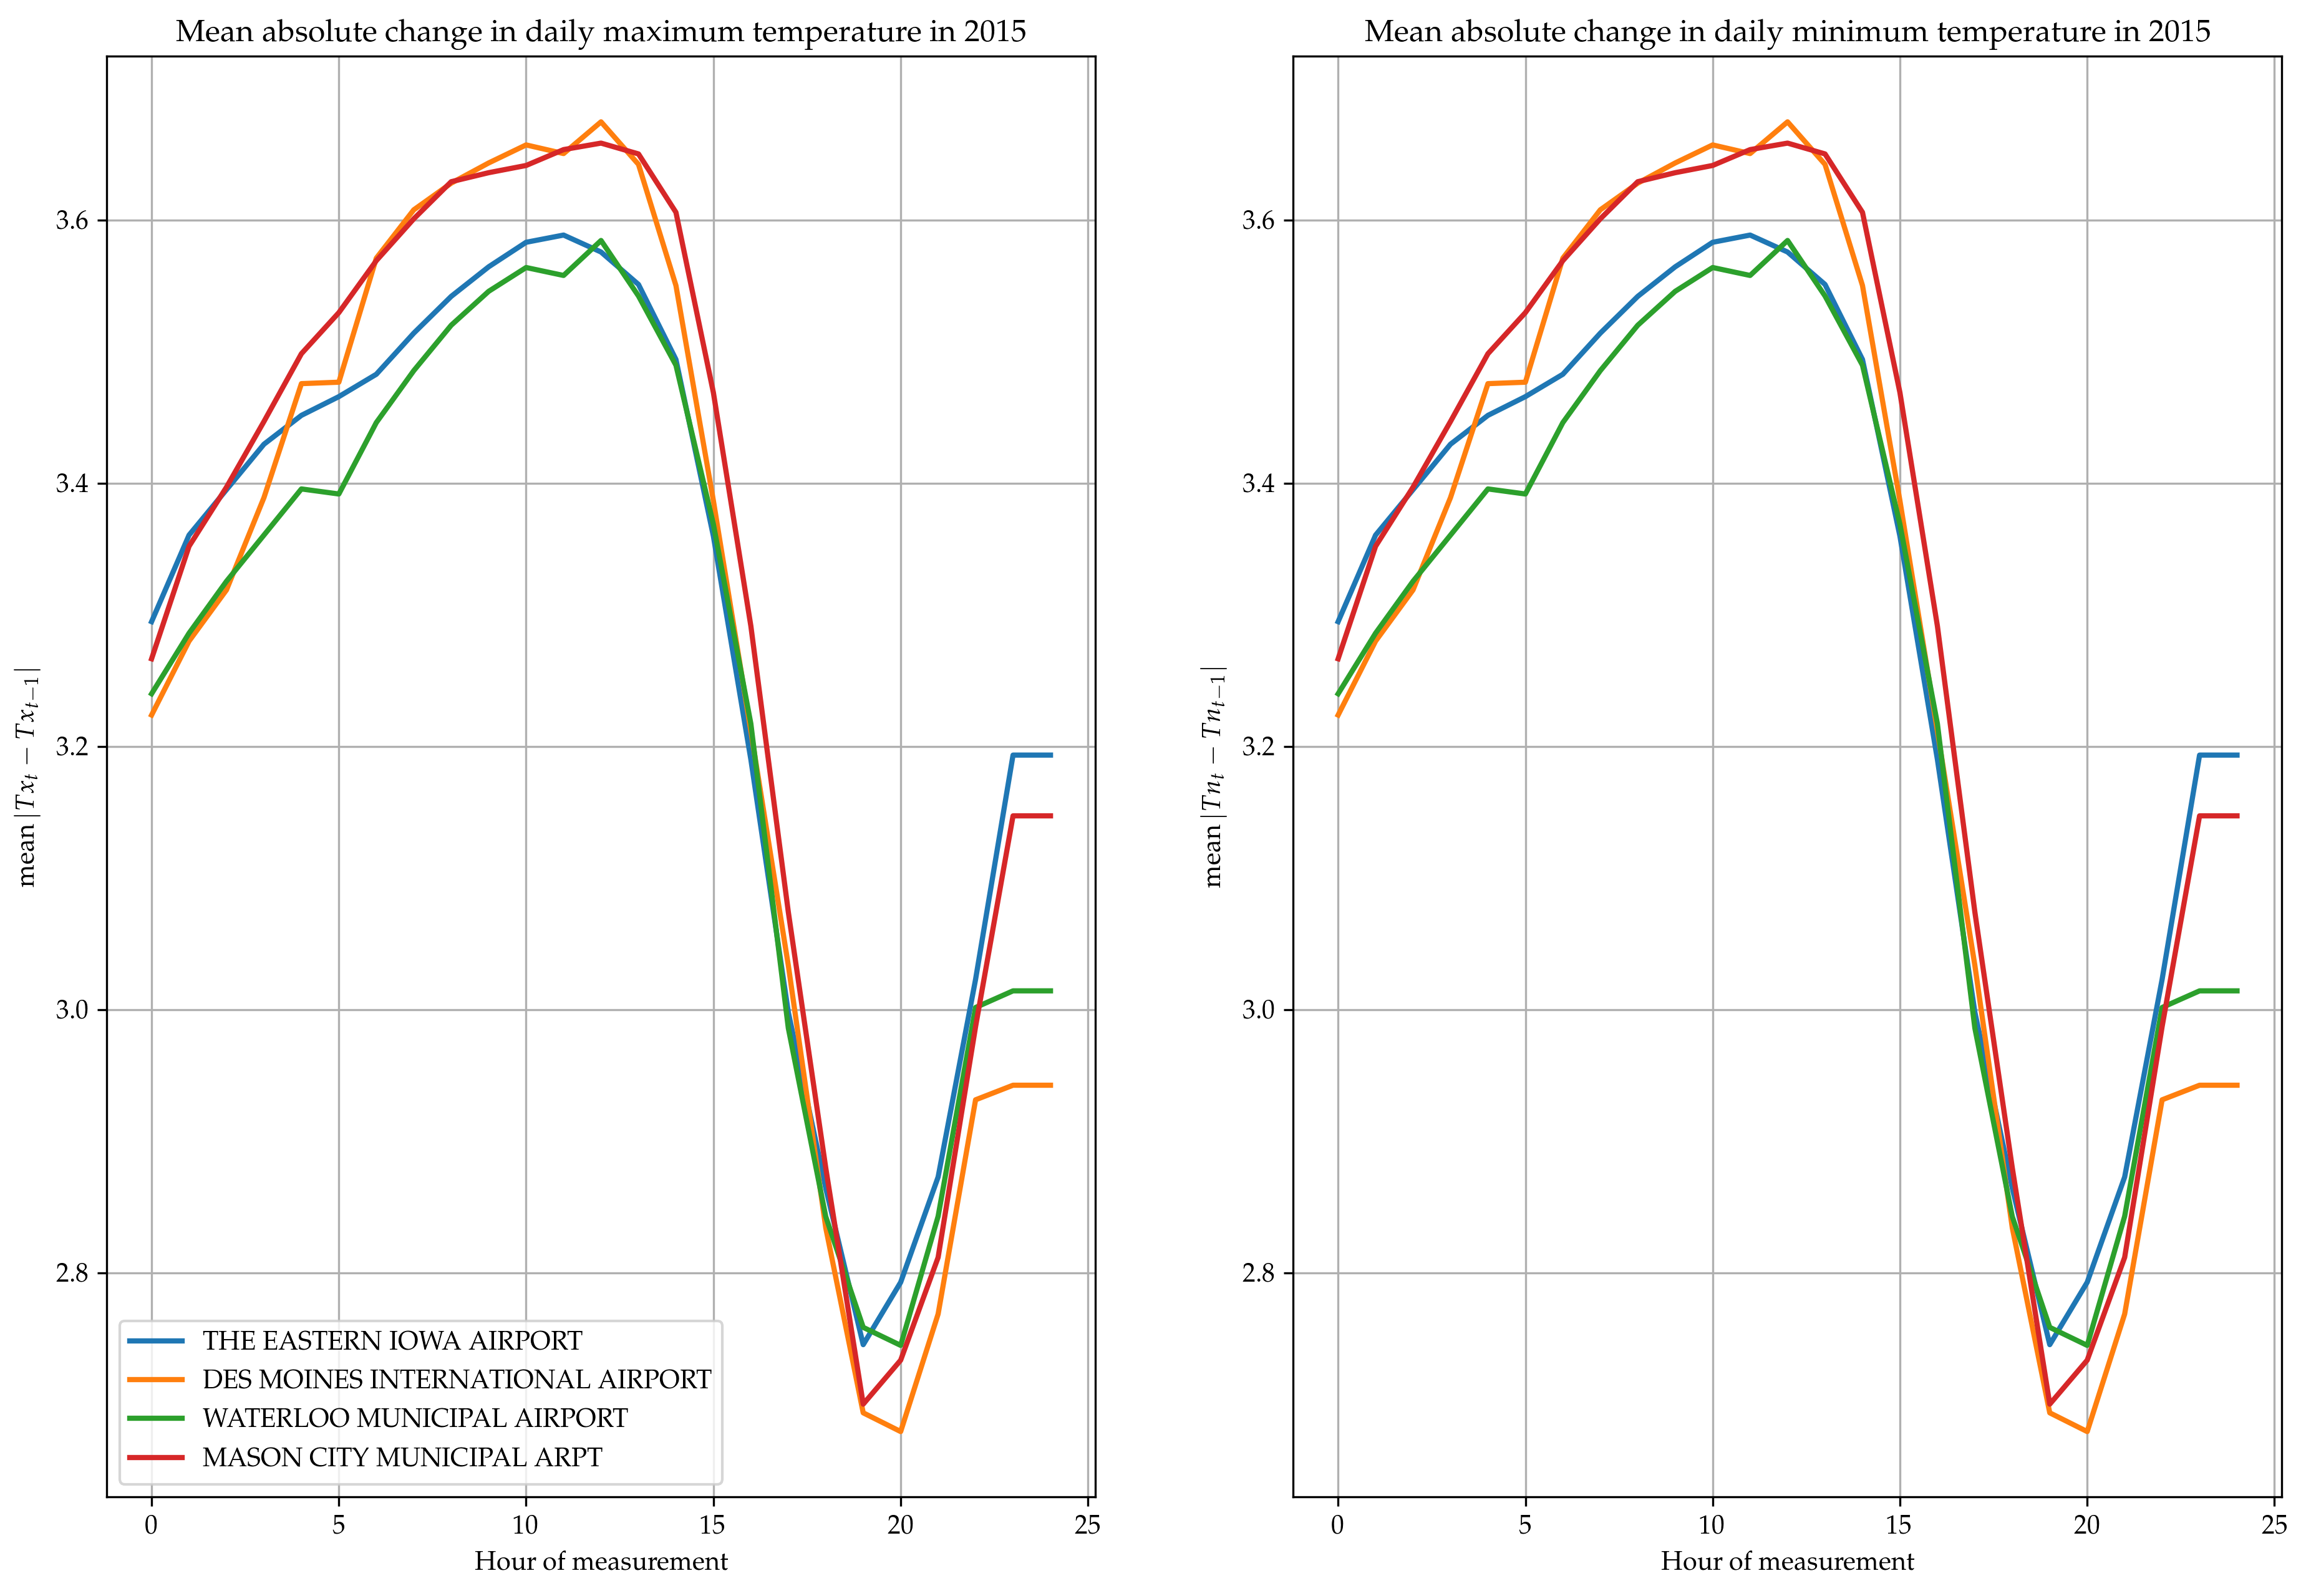

In [8]:
plt.subplot(1,2,1)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx[:Tx].values))))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2, label=get(isdSubset[station,:NAME]))
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tx_{t}-Tx_{t-1} \right|$")
    plt.title("Mean absolute change in daily maximum temperature in 2015")
    plt.xlabel("Hour of measurement")
    plt.grid()
    plt.legend(loc="lower left")
end
plt.subplot(1,2,2)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx[:Tx].values))))
        end
    end

    for station in 1:4
        plt.plot(0:24, meandiff[station], linewidth=2)
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tn_{t}-Tn_{t-1} \right|$")
    plt.title("Mean absolute change in daily minimum temperature in 2015")
    plt.xlabel("Hour of measurement")
    plt.grid(true)
end
plt.gcf()[:set_size_inches](15.0, 10.0)
plt.savefig("figures/waterloo_meanabsdiff.png", bbox_inches="tight")
plt.savefig("figures/waterloo_meanabsdiff.pdf", bbox_inches="tight")
;